<a href="https://colab.research.google.com/github/plaban1981/POCs/blob/main/Copy_of_How_to_turn_screenshots_of_a_table_to_editable_data_using_OpenCV_and_pytesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A table detection, cell recognition and text extraction algorithm to convert tables in images to excel files

## Steps 

1. Use pdfimages from https://poppler.freedesktop.org/ to turn the pages of the pdf into images.

2. Use Tesseract to detect rotation and ImageMagick mogrify to fix it.

3. Use OpenCV to find and extract tables.

4. Use OpenCV to find and extract each cell from the table.

5. Use OpenCV to crop and clean up each cell so that there is no noise that will confuse OCR software.

6.  Use Tesseract to OCR each cell.

7.  Combine the extracted text of each cell into the format you need.

https://stackoverflow.com/questions/47533875/how-to-extract-table-as-text-from-the-pdf-using-python

## text-based PDFs 

#### free solutions. 
    * tabular, 
    * camelot
    * excalibur
    
https://tabula.technology/, 

https://camelot-py.readthedocs.io/en/master/, 

https://excalibur-py.readthedocs.io/en/master/.

In case PDF is image-based or if you find an article with a table online? Why not just take a screenshot and convert it into an excel sheet? Since there seems to be no free or open source software for image-based data (jpg, png, image-based pdf etc.) the idea came up to develop a generic solution to convert tables into editable excel-file

## Getting started

The algorithm consists of three parts: 

    * the first is the table detection and cell recognition with Open CV, 
    * the second the thorough allocation of the cells to the proper row and column and 
    * the third part is the extraction of each allocated cell through Optical Character Recognition (OCR) with pytesseract.

* Clear and detectable lines are necessary for the proper identification of cells. 
* Tables with broken lines, gaps and holes lead to a worse identification and the cells only partially surrounded by lines are not detected. 

In [ ]:
! sudo apt-get update
! sudo apt-get install libleptonica-dev 
! sudo apt-get install tesseract-ocr tesseract-ocr-dev
!sudo apt-get install libtesseract-dev
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install Pillow
! pip install pytesseract
! pip install pdf2image
! pip install PyPDF2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,335 kB]
Hit:12 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:14 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic 

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

## Upload Image

In [ ]:
from google.colab import files
files.upload()

Saving Train_data.JPG to Train_data.JPG


{'Train_data.JPG': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x11\x10Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01;\x00\x02\x00\x00\x00\x17\x00\x00\x08J\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08b\x9c\x9d\x00\x01\x00\x00\x00.\x00\x00\x10\xda\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00>\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

## Import Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Finding tables

In [ ]:
import cv2

def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

    mask = horizontally_dilated + vertically_dilated
    contours, hierarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

TypeError: ignored

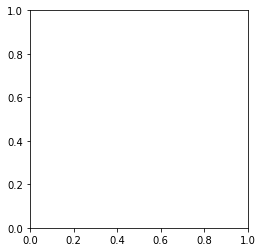

In [ ]:
image = cv2.imread('/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0005.jpg')
img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(find_tables(img_grey))

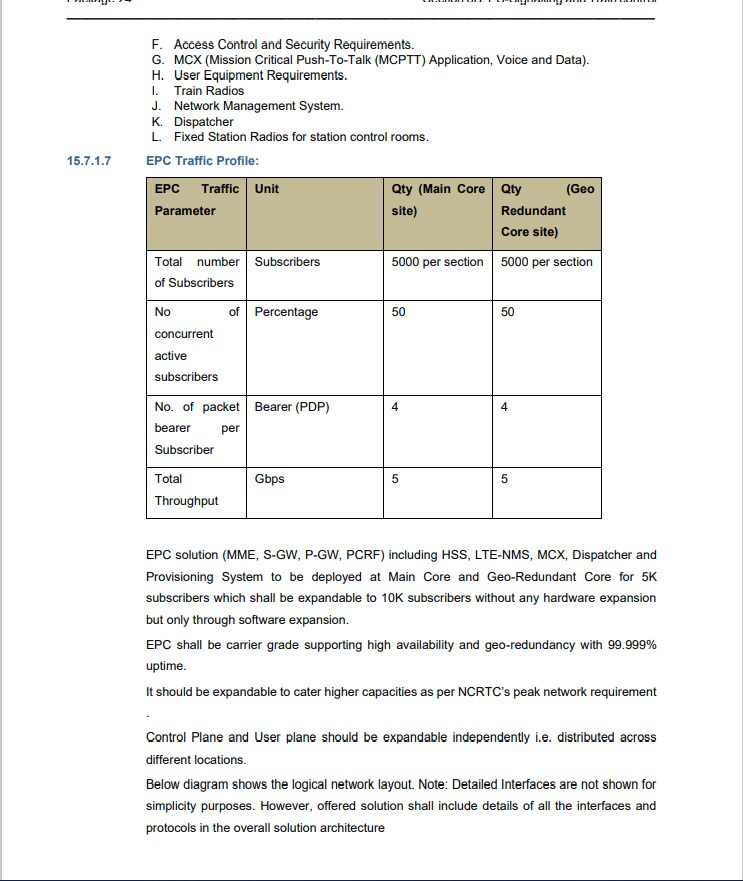

In [ ]:
import PIL
PIL.Image.open('/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0005.jpg')

## Step 1:

* Read the file from the proper path, 
* using thresholding to convert the input image to a binary image and 
* inverting it to get a black background and white lines and fonts.

threshold: 145.0 img_bin shape : (880, 842)


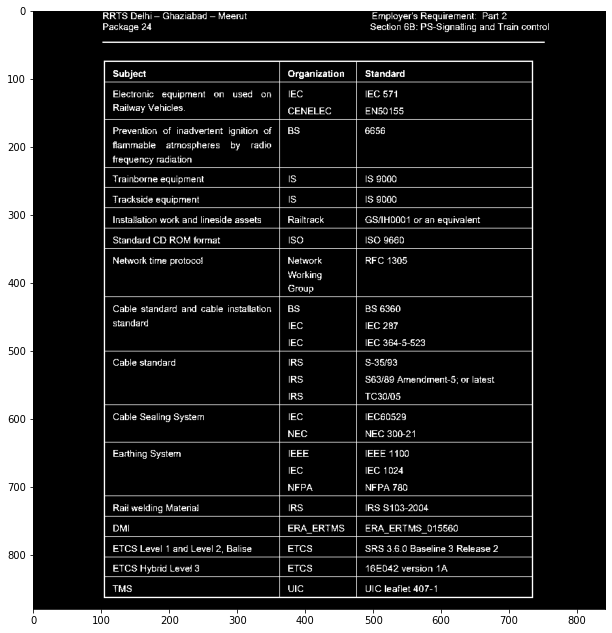

In [ ]:
#read your file
file=r'/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0006.jpg'
img = cv2.imread(file,0)
img.shape
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
print(f'threshold: {thresh} img_bin shape : {img_bin.shape}')
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('/content/cv_inverted.jpeg',img_bin)
#Plotting the image to see the output
plt.figure(figsize=(20,11))
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

## Step 2

Define a kernel to detect rectangular boxes, and followingly the tabular structure. 

* First, we define the length of the kernel and 

* Second the vertical and horizontal kernels to detect 

* Third all vertical lines and all horizontal lines

In [ ]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

## Detection of Vertical Lines

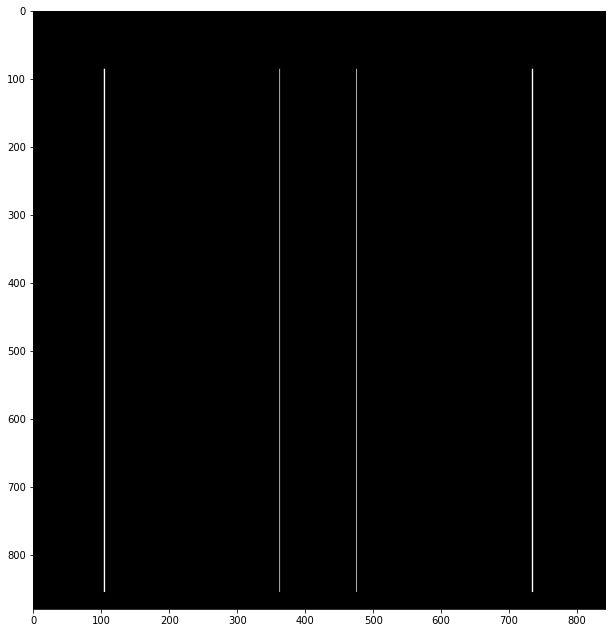

In [ ]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/content/vertical_image.jpeg",vertical_lines)
#Plot the generated image
plt.figure(figsize=(20,11))
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

## Check whether image has horizontal lines

In [ ]:
image = cv2.imread('/content/horizontal_image.jpg')
def is_empty(image):
  if image is None:
    print("Image is empty!!")
    result = True
  else:
    print("Image is not empty!!")
    result = False
  return result

In [ ]:
is_empty(image)

Image is not empty!!


False

## Detect Horizontal Lines

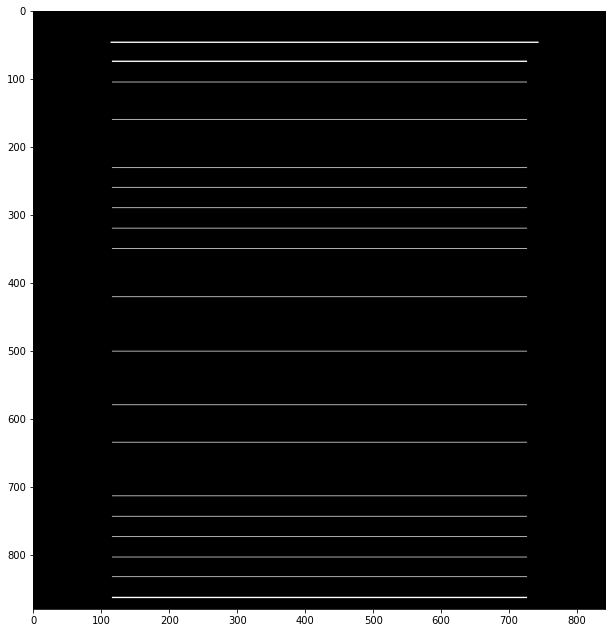

In [ ]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/content/horizontal_image.jpg",horizontal_lines)
#Plot the generated image
plt.figure(figsize=(20,11))
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

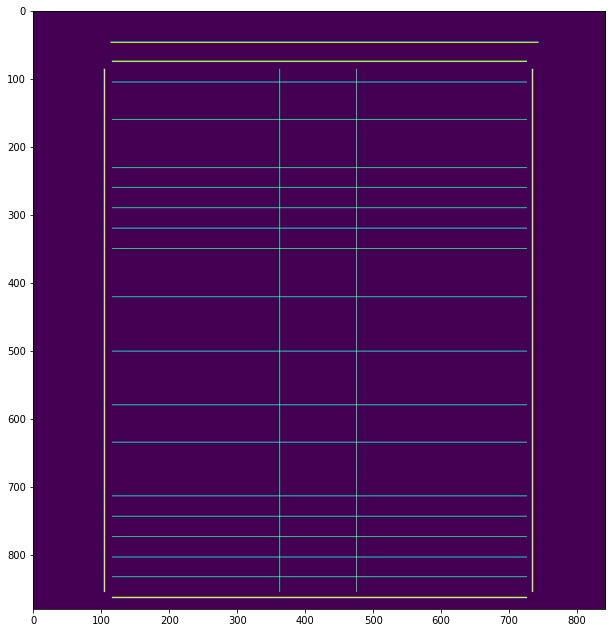

In [ ]:
# create a mask which includes the tables
mask = image_1 + image_2
plt.figure(figsize=(20,11))
plt.imshow(mask)
plt.show()

In [ ]:
vertical_lines.shape 

(504, 637)

In [ ]:
horizontal_lines.shape

(504, 637)

## Check whether image has vertical lines

In [ ]:
image = "/content/vertical_image.jpeg"
is_empty(image)

Image is not empty!!


False

## Step 3:

* Combine the horizontal and vertical lines to a third image, by weighting both with 0.5. 
* The aim is to get a clear tabular structure to detect each cell.

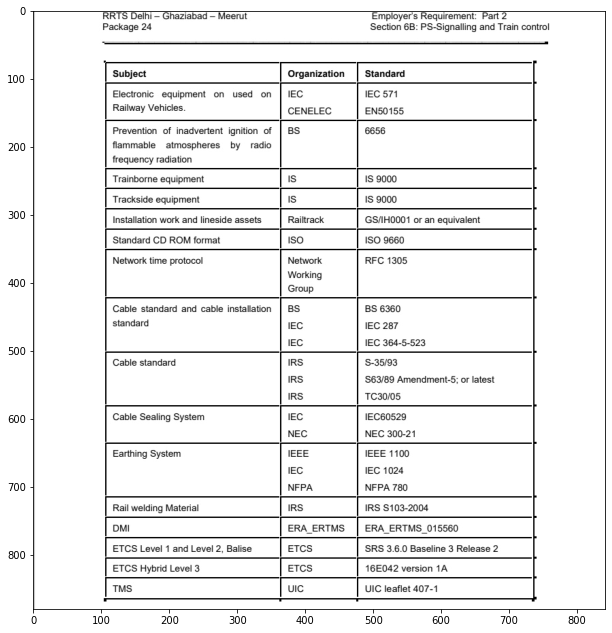

In [ ]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/content/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plt.figure(figsize=(20,11))
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [ ]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

## Function to get a sequence of the contours and to sort them from top-to-bottom

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
      reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
      i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

## Retrieve the cells position proper column and row

* we need to retrieve the height for each cell and store it in the list heights. 
* Then we take the mean from the heights.

In [ ]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

842 880
654 6
638 798
255 27
110 27
254 27
255 52
110 52
254 52
255 68
110 68
254 68
255 26
110 26
254 26
255 27
110 27
254 27
255 27
110 27
254 27
255 27
110 27
254 27
255 68
110 68
254 68
255 77
110 77
254 77
255 76
110 76
254 76
255 52
110 52
254 52
255 76
110 76
254 76
255 27
110 27
254 27
255 27
110 27
254 27
255 27
110 27
254 27
255 26
110 26
254 26
255 27
110 27
254 27


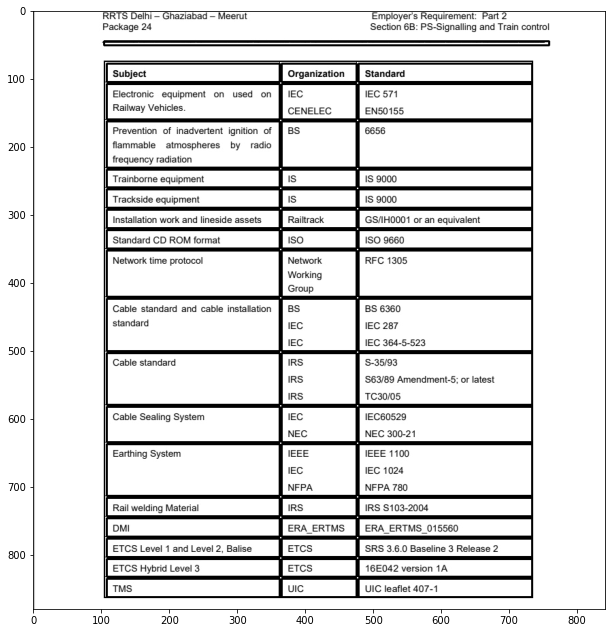

In [ ]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    print(w,h)
    if (w<700 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])

    
plt.figure(figsize=(20,11))        
plotting = plt.imshow(image,cmap='gray')
plt.show()

* Now we have every cell, its location, height and width we need to get the right location within the table. 

* Therefore, we need to know in which row and which column it is located. 

* As long as a box does not differ more than its own (height + mean/2) the box is in the same row. 

* As soon as the height difference is higher than the current (height + mean/2) , we know that a new row starts. 

* Columns are logically arranged from left to right.

In [ ]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[478, 716, 255, 27], [365, 716, 110, 27], [108, 716, 254, 27], [478, 746, 255, 27], [365, 746, 110, 27], [108, 746, 254, 27], [478, 776, 255, 27], [365, 776, 110, 27], [108, 776, 254, 27], [478, 806, 255, 26], [365, 806, 110, 26], [108, 806, 254, 26], [478, 835, 255, 27], [365, 835, 110, 27], [108, 835, 254, 27]]
[[[104, 44, 654, 6], [478, 77, 255, 27], [365, 77, 110, 27], [108, 77, 254, 27], [478, 107, 255, 52], [365, 107, 110, 52], [108, 107, 254, 52]], [[478, 162, 255, 68], [365, 162, 110, 68], [108, 162, 254, 68]], [[478, 233, 255, 26], [365, 233, 110, 26], [108, 233, 254, 26], [478, 262, 255, 27], [365, 262, 110, 27], [108, 262, 254, 27], [478, 292, 255, 27], [365, 292, 110, 27], [108, 292, 254, 27], [478, 322, 255, 27], [365, 322, 110, 27], [108, 322, 254, 27], [478, 352, 255, 68], [365, 352, 110, 68], [108, 352, 254, 68]], [[478, 423, 255, 77], [365, 423, 110, 77], [108, 423, 254, 77]], [[478, 503, 255, 76], [365, 503, 110, 76], [108, 503, 254, 76]], [[478, 582, 255, 52], [365,

## Calculate the maximum number of columns to understand how many columns our final dataframe/table will have.

In [ ]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [ ]:
countcol

15

After having the maximum number of cells we store the midpoint of each column in a list, create an array and sort the values.

In [ ]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [ ]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [ ]:
 len(finalboxes[0])

15

In [ ]:
finalboxes[0]

[[[104, 44, 654, 6], [108, 77, 254, 27], [108, 107, 254, 52]],
 [],
 [],
 [],
 [],
 [[365, 77, 110, 27], [365, 107, 110, 52]],
 [],
 [],
 [],
 [],
 [[478, 77, 255, 27], [478, 107, 255, 52]],
 [],
 [],
 [],
 []]

In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner= ''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                print(out)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, lang='eng',config='--psm 13 --oem 1 -c tessedit_char_whitelist=ABCDEFG0123456789')
                inner = inner +" "+ out
            outer.append(inner.replace("\n",""))


Subject

Electronic equipment on used on
Railway Vehicles.

Organization

IEC
CENELEC

Standard

IEC 571
EN50155

Prevention of inadvertent ignition of
flammable atmospheres by radio
frequency radiation

BS

6656

Trainborne equipment

Trackside equipment

Installation work and lineside assets

Standard CD ROM format

Network time protocol



Railtrack

ISO

Network
Working
Group

IS 9000

IS 9000

GS/IH0001 or an equivalent

ISO 9660

RFC 1305

Cable standard and cable installation
standard

BS
IEC
IEC

BS 6360
IEC 287
IEC 364-5-523

Cable standard

IRS
IRS
IRS

S-35/93
$63/89 Amendment-5; or latest
TC30/05

Cable Sealing System

IEC
NEC

1EC60529
NEC 300-21

Earthing System

IEEE
IEC
NFPA

IEEE 1100
IEC 1024
NFPA 780

Rail welding Material

DMI

ETCS Level 1 and Level 2, Balise

ETCS Hybrid Level 3

TMS

IRS

ERA_ERTMS

ETCS

ETCS

UIC

IRS S103-2004

ERA_ERTMS_015560

SRS 3.6.0 Baseline 3 Release 2

16E042 version 1A

UIC leaflet 4

In [ ]:
import string
outer1 = [ x.replace('\x0c',"") for x in outer]
outer1

['  Subject Electronic equipment on used onRailway Vehicles.',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Organization IECCENELEC',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Standard IEC 571EN50155',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Prevention of inadvertent ignition offlammable atmospheres by radiofrequency radiation',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BS',
 ' ',
 ' ',
 ' ',
 ' ',
 ' 6656',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Trainborne equipment Trackside equipment Installation work and lineside assets Standard CD ROM format Network time protocol',
 ' ',
 ' ',
 ' ',
 ' ',
 '   Railtrack ISO NetworkWorkingGroup',
 ' ',
 ' ',
 ' ',
 ' ',
 ' IS 9000 IS 9000 GS/IH0001 or an equivalent ISO 9660 RFC 1305',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Cable standard and cable installationstandard',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BSIECIEC',
 ' ',
 ' ',
 ' ',
 ' ',
 ' BS 6360IEC 287IEC 364-5-523',
 ' ',
 ' ',
 ' ',
 ' ',
 ' Cable standard',
 ' ',
 ' ',
 ' ',
 ' ',
 ' IRSIRSIRS',
 ' ',
 ' ',
 ' ',
 ' ',
 ' S-35/93$63/89 Amendment-5; or latestTC30/05',
 ' ',
 ' ',
 ' 

In [ ]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe.head())
data = dataframe.style.set_properties(align="right")
print(data)
#Converting it in a excel-file
#data.to_excel('output.xlsx')
dataframe.to_csv('output.csv',index=False)

                                                  0  1  2  3   ... 11 12 13 14
0    Subject\n Electronic equipment on used on\...           ...            
1   Prevention of inadvertent ignition of\nflamma...           ...            
2   Trainborne equipment\n Trackside equipment\n...           ...            
3   Cable standard and cable installation\nstanda...           ...            
4                                  Cable standard\n           ...            

[5 rows x 15 columns]


## Fix the below issue encountered
TesseractNotFoundError: tesseract is not installed or it's not in your PATH.

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,711 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

## Fix the below issue
(2, 'Usage: pytesseract [-l lang] input_file') on Google Colab

## extract the values

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner= ' '
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                out = pytesseract.image_to_string(erosion, config='--psm 3')
                """
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                """
                inner = inner +" "+ out
            outer.append(inner)

In [ ]:
len(outer)

120

In [ ]:
len(outer[1])

1

In [ ]:
outer[0].split("\n")

['  \x0c Subject',
 '\x0c Electronic equipment on used on',
 'Railway Vehicles.',
 '\x0c']

In [ ]:
import re
lines = " ".join([line.strip() for line in outer[0].split("\n") if not re.match(r'^\x0c*$', line)])

In [ ]:
lines

'Subject Electronic equipment on used on Railway Vehicles.'

In [ ]:
outer[1]

' '

In [ ]:
outer1 = []
for item in outer:
  if len(item) > 0:
    outer1.append(" ".join([line.strip() for line in item.split("\n") if not re.match(r'^\x0c*$', line)]))

In [ ]:
outer1

['Subject Electronic equipment on used on Railway Vehicles.',
 '',
 '',
 '',
 '',
 'Organization IEC CENELEC',
 '',
 '',
 '',
 '',
 'Standard IEC 571 EN50155',
 '',
 '',
 '',
 '',
 'Prevention of inadvertent ignition of flammable atmospheres by radio frequency radiation',
 '',
 '',
 '',
 '',
 'BS',
 '',
 '',
 '',
 '',
 '6656',
 '',
 '',
 '',
 '',
 'Trainborne equipment Trackside equipment Installation work and lineside assets Standard CD ROM format Network time protocol',
 '',
 '',
 '',
 '',
 'Railtrack ISO Network Working Group',
 '',
 '',
 '',
 '',
 'IS 9000 IS 9000 GS/IH0001 or an equivalent ISO 9660 RFC 1305',
 '',
 '',
 '',
 '',
 'Cable standard and cable installation standard',
 '',
 '',
 '',
 '',
 'BS IEC IEC',
 '',
 '',
 '',
 '',
 'BS 6360 IEC 287 IEC 364-5-523',
 '',
 '',
 '',
 '',
 'Cable standard',
 '',
 '',
 '',
 '',
 'IRS IRS IRS',
 '',
 '',
 '',
 '',
 'S-35/93 $63/89 Amendment-5; or latest TC30/05',
 '',
 '',
 '',
 '',
 'Cable Sealing System',
 '',
 '',
 '',
 '',
 'IEC NE

In [ ]:
len(outer1[1])

24

In [ ]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer1)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel('/content/output.xlsx')

                                                  0  1  2  3   ... 11 12 13 14
0  Subject Electronic equipment on used on Railwa...           ...            
1  Prevention of inadvertent ignition of flammabl...           ...            
2  Trainborne equipment Trackside equipment Insta...           ...            
3     Cable standard and cable installation standard           ...            
4                                     Cable standard           ...            
5                               Cable Sealing System           ...            
6                                    Earthing System           ...            
7  Rail welding Material DMI ETCS Level 1 and Lev...           ...            

[8 rows x 15 columns]


In [ ]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join('/content/drive/MyDrive/ZeoanAI_Poc', "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            print(path)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [ ]:
f = main('/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0005.jpg')

In [ ]:
! pip install table_ocr

     |████████████████████████████████| 33.4 MB 6.7 kB/s 
     |████████████████████████████████| 49.9 MB 29 kB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=8f4c44f1e10e663bda38f252b3fb5d62922887f0b7a3146ec7a1f19d21c4827c
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## OCR_TO_FIle

In [ ]:
import csv
import io
import os


def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(f) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

print(text_files_to_csv(files))

FileNotFoundError: ignored

## How to extract tables from PDF files in Python using camelot and tabula libraries and export them into several formats such as CSV, excel, Pandas dataframe and HTML.

https://www.thepythoncode.com/article/extract-pdf-tables-in-python-camelot

In [ ]:
!pip install camelot-py[cv] tabula-py

     |████████████████████████████████| 40 kB 22 kB/s 
     |████████████████████████████████| 12.0 MB 10.3 MB/s 
     |████████████████████████████████| 5.6 MB 34.0 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 11.7 MB 16.7 MB/s 
     |████████████████████████████████| 3.0 MB 51.5 MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=ab308e1a0041eab0b2a04d0f83ca9433b12e32be7043f0e5e45354a8e30a6aeb
  Stored in directory: /root/.cache/pip/wheels/80/1a/24/648467ade3a77ed20f35cfd2badd32134e96dd25ca811e64b3
Successfully built PyPDF2


In [ ]:
! apt install ghostscript python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 11 newly installed, 0 to remove and 37 not upgraded.
Need to get 14.1 MB of archives.
After this operation, 49.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-droid-fallback all 1:6.0.

In [ ]:
from google.colab import files
files.upload()

Saving foo.pdf to foo.pdf


{'foo.pdf': b'%PDF-1.4\n%\xe2\xe3\xcf\xd3\n2 0 obj <</Producer (GPL Ghostscript 9.06) /CreationDate (D:20130405114921+01\'00\') /ModDate (D:20130405114921+01\'00\') >> endobj\r\n11 0 obj <</Type /ExtGState /BM /Normal /OPM 1 /TK true >> endobj\r\n12 0 obj <</BaseFont /EJJILL+TimesNewRomanPSMT /FontDescriptor 13 0 R /ToUnicode 41 0 R /Type /Font /FirstChar 32 /LastChar 150 /Widths [250 0 0 0 0 833 0 0 333 333 0 0 250 333 250 278 500 500 500 500 500 500 500 500 500 0 278 0 0 0 0 0 0 722 0 667 722 611 556 722 722 333 0 722 611 0 722 722 556 0 667 556 611 0 0 0 0 0 0 333 0 333 0 0 0 444 500 444 500 444 333 500 500 278 278 500 278 778 500 500 500 500 333 389 278 500 500 722 500 500 444 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 333 444 444 0 500 ] /Subtype /TrueType >> endobj\r\n13 0 obj <</Type /FontDescriptor /FontName /EJJILL+TimesNewRomanPSMT /FontBBox [-76 -215 798 694 ] /Flags 4 /Ascent 694 /CapHeight 694 /Descent -215 /ItalicAngle 0 /StemV 119 /MissingWidth 777 /FontFile2 37 0 R >

In [ ]:
import camelot

# PDF file to extract tables from
file = "/content/finance_img.pdf"

In [ ]:
# extract all the tables in the PDF file
tables = camelot.read_pdf(file)

In [ ]:
# number of tables extracted
print("Total tables extracted:", tables.n)

Total tables extracted: 0


In [ ]:
df1 = tables[0].df

In [ ]:
df1

0            1  ...                  5                 6
0  Cycle \nName  KI \n(1/km)  ...                                     
1                             ...  Eliminate \nStops  Decreased \nIdle
2        2012_2         3.30  ...              29.2%             17.4%
3        2145_1         0.68  ...               9.5%              2.7%
4        4234_1         0.59  ...               8.5%              3.3%
5        2032_2         0.17  ...               2.7%              1.2%
6        4171_1         0.07  ...               2.1%              0.5%

[7 rows x 7 columns]

In [ ]:
# print the first table as Pandas DataFrame
print(tables[0].df).to_csv('table.csv',index=False)

              0            1  ...                  5                 6
0  Cycle \nName  KI \n(1/km)  ...                                     
1                             ...  Eliminate \nStops  Decreased \nIdle
2        2012_2         3.30  ...              29.2%             17.4%
3        2145_1         0.68  ...               9.5%              2.7%
4        4234_1         0.59  ...               8.5%              3.3%
5        2032_2         0.17  ...               2.7%              1.2%
6        4171_1         0.07  ...               2.1%              0.5%

[7 rows x 7 columns]


AttributeError: ignored

In [ ]:
!pip install PyMuPDF Pillow

     |████████████████████████████████| 6.4 MB 5.9 MB/s 


In [ ]:
import fitz # PyMuPDF
import io
from PIL import Image

In [ ]:
# open the file
pdf_file = fitz.open("/content/drive/MyDrive/ZeoanAI_Poc/HR_Policy-GGIAL.pdf")

[!] No images found on page 0
[+] Found a total of 7 images in page 1
[!] No images found on page 2
[!] No images found on page 3
[!] No images found on page 4
[+] Found a total of 1 images in page 5
[!] No images found on page 6
[!] No images found on page 7
[!] No images found on page 8
[+] Found a total of 1 images in page 9
[!] No images found on page 10
[+] Found a total of 1 images in page 11
[+] Found a total of 1 images in page 12
[+] Found a total of 1 images in page 13
[+] Found a total of 1 images in page 14
[!] No images found on page 15
[+] Found a total of 1 images in page 16
[!] No images found on page 17
[+] Found a total of 1 images in page 18
[+] Found a total of 4 images in page 19
[+] Found a total of 1 images in page 20
[!] No images found on page 21
[+] Found a total of 1 images in page 22
[!] No images found on page 23
[+] Found a total of 1 images in page 24
[!] No images found on page 25
[!] No images found on page 26
[!] No images found on page 27
[!] No image

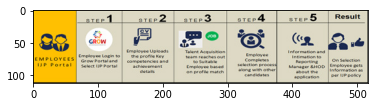

In [ ]:
# iterate over PDF pages
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    image_list = page.getImageList()
    # printing number of images found in this page
    if image_list:
        print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
    else:
        print("[!] No images found on page", page_index)
    for image_index, img in enumerate(page.getImageList(), start=1):
        # get the XREF of the image
        xref = img[0]
        # extract the image bytes
        base_image = pdf_file.extractImage(xref)
        image_bytes = base_image["image"]
        # get the image extension
        image_ext = base_image["ext"]
        # load it to PIL
        image = Image.open(io.BytesIO(image_bytes))
        plt.imshow(image)
        # save it to local disk
        image.save(open(f"image{page_index+1}_{image_index}.{image_ext}", "wb"))

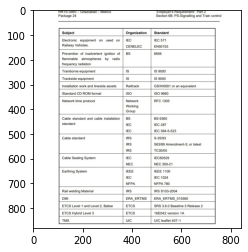

In [ ]:
plt.imshow(Image.open("/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0006.jpg"))

In [ ]:
box = [1.5, 22,3.8,26.741]
fc = 28.28
         
for i in range(0, len(box)):
    box[i] *= fc

In [ ]:
!curl -L -O https://github.com/chezou/tabula-py/raw/master/tests/resources/data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   148  100   148    0     0    721      0 --:--:-- --:--:-- --:--:--   721
100 28330  100 28330    0     0  74947      0 --:--:-- --:--:-- --:--:-- 74947


In [ ]:
!pip show tabula-py

In [ ]:
!java -jar /usr/local/lib/python3.7/dist-packages/tabula/tabula-2.3.0-jar-with-dependencies.jar --guess data.pdf


Error: Unable to access jarfile /usr/local/lib/python3.7/dist-packages/tabula/tabula-2.3.0-jar-with-dependencies.jar


In [ ]:
import pandas as pd
import tabula
file = "/content/finance_img.pdf"
df = tabula.read_pdf(file, pages = '0', multiple_tables = True)
print(df)

Error from tabula-java:
Exception in thread "main" java.lang.IndexOutOfBoundsException: Page number does not exist.
	at technology.tabula.ObjectExtractor.extractPage(ObjectExtractor.java:19)
	at technology.tabula.PageIterator.next(PageIterator.java:30)
	at technology.tabula.CommandLineApp.extractFile(CommandLineApp.java:161)
	at technology.tabula.CommandLineApp.extractFileTables(CommandLineApp.java:124)
	at technology.tabula.CommandLineApp.extractTables(CommandLineApp.java:106)
	at technology.tabula.CommandLineApp.main(CommandLineApp.java:76)




CalledProcessError: ignored

In [ ]:
import tabula as tb
regions_raw = tb.read_pdf(file, pages=[0],output_format="json")

Error from tabula-java:
Exception in thread "main" java.lang.IndexOutOfBoundsException: Page number does not exist.
	at technology.tabula.ObjectExtractor.extractPage(ObjectExtractor.java:19)
	at technology.tabula.PageIterator.next(PageIterator.java:30)
	at technology.tabula.CommandLineApp.extractFile(CommandLineApp.java:161)
	at technology.tabula.CommandLineApp.extractFileTables(CommandLineApp.java:124)
	at technology.tabula.CommandLineApp.extractTables(CommandLineApp.java:106)
	at technology.tabula.CommandLineApp.main(CommandLineApp.java:76)




CalledProcessError: ignored

## Detecting tables from Images

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip3 install table_ocr

     |████████████████████████████████| 33.4 MB 6.0 kB/s 
     |████████████████████████████████| 49.9 MB 31 kB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=44e63decaae5cacc4561a4c23abaad0fd1a780a8791dcb29b72a2f1c8f679b91
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import argparse
im
from table_ocr.ocr_image import main

description="""Takes a single argument that is the image to OCR.
Remaining arguments are passed directly to Tesseract.
Attempts to make OCR more accurate by performing some modifications on the image.
Saves the modified image and the OCR text in an `ocr_data` directory.
Filenames are of the format for training with tesstrain."""
parser = argparse.ArgumentParser(description=description)
parser.add_argument("image", help="filepath of image to perform OCR")

args, tess_args = parser.parse_known_args()
print(main(args.image, tess_args))

In [ ]:
import requests
import table_ocr.util
import table_ocr.extract_tables
import table_ocr.extract_cells
import table_ocr.ocr_image
import table_ocr.ocr_to_csv

In [ ]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

In [ ]:
os.path.splitext('/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png')[1]

'.png'

In [ ]:
import cv2
import numpy as np
image_filename = '/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png'
image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
print(image.shape)
image = find_tables(image)[0]
cv2.imwrite("/content/example-table.png", image)

(869, 1004)


IndexError: ignored

In [ ]:
image

array([], dtype=float64)

In [ ]:
file = '/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png'
results = find_tables(file)


error: ignored

In [ ]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
import table_ocr
from table_ocr.ocr_image import main
file = '/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png'
image_tables = table_ocr.extract_tables.main(file)

AttributeError: ignored

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file = '/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png'
im1 = cv2.imread(file, 0)
im = cv2.imread(file)

## Apply a inverse binary threshold to the image. 

* In this method we set minimum threshold value as 180 and max being 255.

* Binary threshold converts any pixel value above 180 to 255 and below 180 to 0. 

* THRESH_BINARY_INV is the inverse of binary threshold.

In [ ]:
ret,thresh_value = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)

## Set Kernel Size

Then we will set a kernel of size (5,5) and perform image dilation with it. 

* We can tweak the kernel size and number of iteration as per our need and requirements.

In [ ]:
kernel = np.ones((5,5),np.uint8)
dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)

## Find the contours around the using OpenCV using findContours.

In [ ]:
contours, hierarchy = cv2.findContours(dilated_value,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
len(contours), hierarchy.shape

(253, (1, 253, 4))

In [ ]:
contours[0].shape

(147, 1, 2)

## Draw the contours 

* After the contours are detected and saved in contours variable we draw the contours on our image. 

* Draw the contours on the original image 0n which no manipulations has been applied on it.

In [ ]:
contours, hierarchy = cv2.findContours(dilated_value,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cordinates = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cordinates.append((x,y,w,h))
    #bounding the images
    if y< 50:
      cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),1)
        


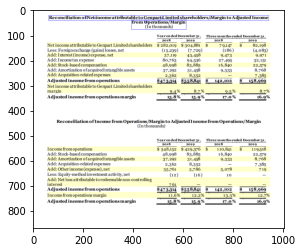

In [ ]:
plt.imshow(im)

In [ ]:
cv2.namedWindow('table',cv2.WINDOW_NORMAL)

## Convert the image to PDF using Python

In [ ]:
from PIL import Image

image1 = Image.open('/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png')
im1 = image1.convert('RGB')
im1.save('finance.pdf')

In [ ]:
# To be more precisely, it's better to use `{sys.executable} -m pip install tabula-py`
!pip install -q tabula-py

In [ ]:
import tabula
pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/Tables.pdf"

dfs = tabula.read_pdf(pdf_path,pages="1", stream=True,multiple_tables=True)
# read_pdf returns list of DataFrames
print(len(dfs))
dfs

0


[]

In [ ]:
tabula.read_pdf(pdf_path,pages="4-7,8", stream=True,multiple_tables=True,output_format="json")[5]

{'bottom': 539.0,
 'data': [[{'height': 7.460005760192871,
    'left': 53.98,
    'text': 'LTA (Per Annum)Level Petrol Allowance',
    'top': 409.58,
    'width': 197.75999450683594},
   {'height': 0.0, 'left': 0.0, 'text': '', 'top': 0.0, 'width': 0.0}],
  [{'height': 0.0, 'left': 0.0, 'text': '', 'top': 0.0, 'width': 0.0},
   {'height': 3.859999895095825,
    'left': 191.72,
    'text': '(May choose any one amount)',
    'top': 416.78,
    'width': 77.41998291015625}],
  [{'height': 7.250006198883057,
    'left': 51.16,
    'text': '` 16,000/- per month LX & LA',
    'top': 427.29,
    'width': 107.15000915527344},
   {'height': 0.0, 'left': 0.0, 'text': '', 'top': 0.0, 'width': 0.0}],
  [{'height': 3.6500000953674316,
    'left': 101.11,
    'text': '(including driver salary)',
    'top': 434.49,
    'width': 57.429996490478516},
   {'height': 0.0, 'left': 0.0, 'text': '', 'top': 0.0, 'width': 0.0}],
  [{'height': 7.250006198883057,
    'left': 57.88,
    'text': '` 16,000/- per mon

In [ ]:
dfs[5].to_dict()

{'LTA (Per Annum)Level Petrol Allowance': {0: nan,
  1: '` 16,000/- per month LX & LA',
  2: '(including driver salary)',
  3: '` 16,000/- per month LB',
  4: '(including driver salary)',
  5: '` 12,000/- per month LC to LE',
  6: '(including driver salary)',
  7: 'LF to LH ` 6,000/- per month',
  8: '` 16,000/- per month',
  9: 'PA',
  10: '(including driver salary)',
  11: '` 16,000/- per month PB',
  12: '(including driver salary)',
  13: '` 12,000/- per month PC to PE',
  14: '(including driver salary)'},
 'Unnamed: 0': {0: '(May choose any one amount)',
  1: nan,
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: '` 1,00,000/ ` 75,000/',
  7: '` 50,000/ ` 25,000/',
  8: '` 15,000',
  9: nan,
  10: nan,
  11: nan,
  12: nan,
  13: nan,
  14: nan}}

In [ ]:

dfs[5].to_csv('table.csv')

## PYPDF2 to read pdfs

In [ ]:
!pip install PyPDF2

     |████████████████████████████████| 77 kB 4.6 MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=a103448c8a5c4ec0f2644c71474a251d67e0c760c3ada337df98e63070e70e3e
  Stored in directory: /root/.cache/pip/wheels/80/1a/24/648467ade3a77ed20f35cfd2badd32134e96dd25ca811e64b3
Successfully built PyPDF2


## Count the number of pages in the pdf

In [ ]:
from PyPDF2 import PdfFileReader
pdf = PdfFileReader(open(pdf_path,'rb'))
no_pages = pdf.getNumPages()

## process the documents having tables using tabula

In [ ]:
for i in range(1,no_pages +1):
  dfs = tabula.read_pdf(pdf_path,pages=str(i), stream=True,multiple_tables=True)
  # read_pdf returns list of DataFrames
  print(len(dfs))
  if len(dfs) > 0:
    print(dfs[0].head())


0
0
0
1
   Unnamed: 0 Unnamed: 1                           - Marriage Gift
0         NaN        NaN                   - Annual Health Checkup
1         NaN        NaN      - Employee Emergency Response Centre
2         NaN        NaN     - Merit Rewards to Employees children
3         7.0          |  Flexible Compensation & Benefit Plan (FC
4         8.0          |                                Governance
2
                         JRL / Band DescriptionGrade
0  Roles driving and impacting the strategy, over...
1  line of the entity (or GMR, as the case may be...
2  functional / sector level imperatives and tran...
3  goals for generating revenue/supporting the bu...
4  LA Full-fledged professionals who will be head...
1
                         JRL / Band DescriptionGrade  ... Unnamed: 6
0                                    1. Jobs at this  ...        the
1  technical discipline and will tend to be heads...  ...        NaN
2                                    within a sector  ...    

In [ ]:
import tabula
#pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/HR_Policy-GGIAL.pdf"
pdf_path = "/content/finance.pdf"
pdfs = tabula.read_pdf(pdf_path,pages= '1', stream=True)

In [ ]:
len(pdfs)

0

In [ ]:
import tabula
pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/HR_Policy-GGIAL.pdf"
tabula.read_pdf(pdf_path,pages= '5', stream=True)

[                          JRL / Band DescriptionGrade
 0   Roles driving and impacting the strategy, over...
 1   line of the entity (or GMR, as the case may be...
 2   functional / sector level imperatives and tran...
 3   goals for generating revenue/supporting the bu...
 4   LA Full-fledged professionals who will be head...
 5   Integration within their sectors and will have...
 6   LB Delivery of results would be focused to sec...
 7   LC Seasoned professionals who have deep expert...
 8   Managerial function/area and will generally be...
 9   LD area of work within the verticals/ sub-vert...
 10                                                 LE
 11                                                 LF
 12  Supervising others / Individual Contributor to...
 13                  LH department/ functional purpose
 14                                                 LI
 15                                                 LJ,
                          JRL / Band DescriptionGrade
 0  1. Job

## Using pdfplumber

In [ ]:
!pip install pdfplumber

     |████████████████████████████████| 45 kB 1.7 MB/s 
     |████████████████████████████████| 5.6 MB 8.2 MB/s 
     |████████████████████████████████| 139 kB 48.3 MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.28-py3-none-any.whl size=32240 sha256=5924b1fc962db98579d67cc10c656779a335ffa588435649eeb5ef6a4f5eca52
  Stored in directory: /root/.cache/pip/wheels/f2/b1/a0/c0a77b756d580f53b3806ae0e0b3ec945a8d05fca1d6e10cc1
Successfully built pdfplumber


In [ ]:
! pip install tesseract
! pip install tesseract-ocr

     |████████████████████████████████| 45.6 MB 1.2 MB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562569 sha256=c88c9bd8947ea016c1e18fe49de7a059c4fdda273b85df432b6b117a0fad9299
  Stored in directory: /root/.cache/pip/wheels/01/3f/af/2f732560b9c4e51dd131bcbc6b7466a3124d15ab3fd393f85a
Successfully built tesseract
  Created wheel for tesseract-ocr: filename=tesseract_ocr-0.0.1-cp37-cp37m-linux_x86_64.whl size=117080 sha256=e3f9e8202b6cc6f932ba08f98cbbf314e87c0b46bde46d52b9a8bce52ed96adc
  Stored in directory: /root/.cache/pip/wheels/0e/b9/24/fe5bca126cccef80975769b5472196f9485fe1512e50b3391e
Successfully built tesseract-ocr


In [ ]:
import pdfplumber
pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/HR_Policy-GGIAL.pdf"
with pdfplumber.open(pdf_path) as pdf:
    first_page = pdf.pages[5]
    print(first_page.chars[5])
    print(first_page.extract_table())

{'fontname': 'TNUWAM+Marine-Light', 'adv': Decimal('0.557'), 'upright': True, 'x0': Decimal('217.474'), 'y0': Decimal('2.764'), 'x1': Decimal('221.095'), 'y1': Decimal('9.264'), 'width': Decimal('3.620'), 'height': Decimal('6.500'), 'size': Decimal('6.500'), 'object_type': 'char', 'page_number': 6, 'stroking_color': None, 'non_stroking_color': (0, 0, 0, 0), 'text': 'P', 'top': Decimal('557.665'), 'bottom': Decimal('564.165'), 'doctop': Decimal('3392.310')}
[['Band', 'JRL / \nGrade', 'Description'], ['Integration', 'PB', '1.  Jobs at this level would require in-depth understanding of the \ntechnical discipline and will tend to be heads of specialist functions \nwithin a sector\n2. Jobs at this level are responsible for leading specialist team in a \ntechnical discipline which must deliver specific, measurable objectives \nthrough the management and coordination of internal resources or \nthe development of relationships and coordination with external \n“partners”'], ['Managerial', 'PC',

## How to extract data from image that contains tabular data? : PYTESSERACT
- pytesseract
- supports scanned pdfs after converting into images

In [ ]:
! sudo apt-get update
! sudo apt-get install libleptonica-dev 
! sudo apt-get install tesseract-ocr tesseract-ocr-dev
!sudo apt-get install libtesseract-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,428 kB]
Hit:14 http://ppa.launchpad.net/cran/libgit2/ubuntu bio

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 56 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,090 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 155124 files and directories currently installed.)
Preparing to unpack .../tesserac

In [ ]:
! pip install Pillow
! pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=30776abee51b04ac27ed1c9396fa9c3deff54d6eab3fa9bac15078c0bd0bb20e
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


## Converting PDF to image


In [ ]:
! pip install pdf2image

https://nanonets.com/blog/ocr-with-tesseract/#pagesegmentationmodes

https://towardsdatascience.com/extracting-text-from-scanned-pdf-using-pytesseract-open-cv-cd670ee38052

https://www.geeksforgeeks.org/reading-text-from-the-image-using-tesseract/

## Example 0

In [ ]:
from google.colab import files
files.upload()

Saving Amrit_Table_crop.jpeg to Amrit_Table_crop.jpeg


{'Amrit_Table_crop.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe17lExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x06\x00\x0b\x00\x02\x00\x00\x00&\x00\x00\x08b\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x011\x00\x02\x00\x00\x00&\x00\x00\x08\x88\x012\x00\x02\x00\x00\x00\x14\x00\x00\x08\xae\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08\xc2\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00V\x00\x00\x11F\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

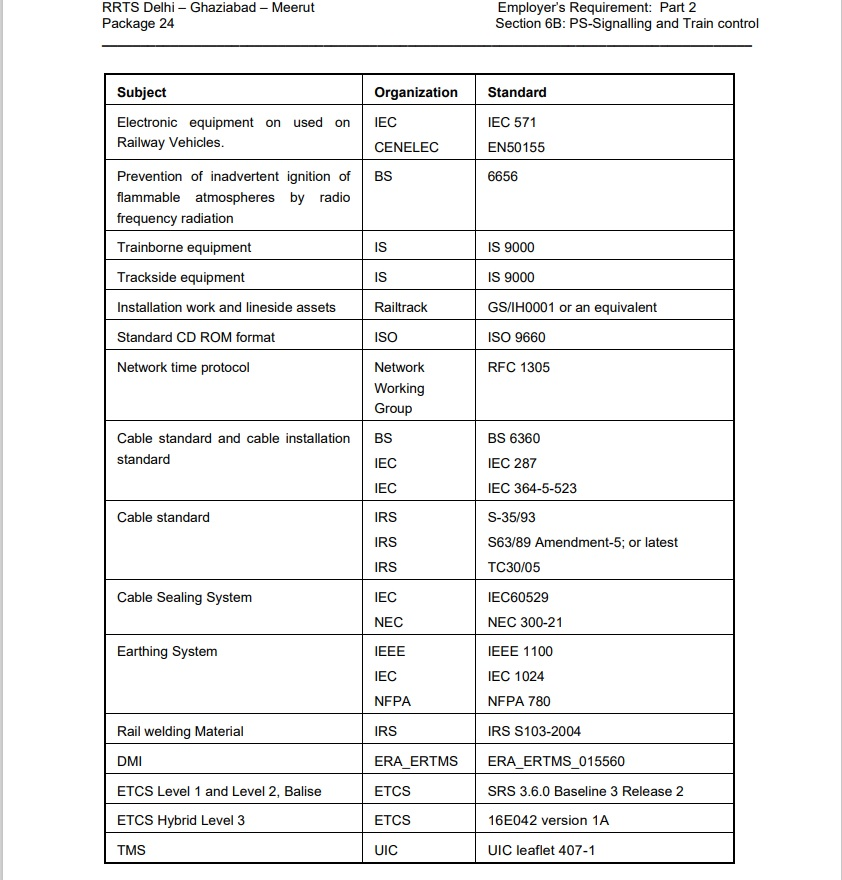

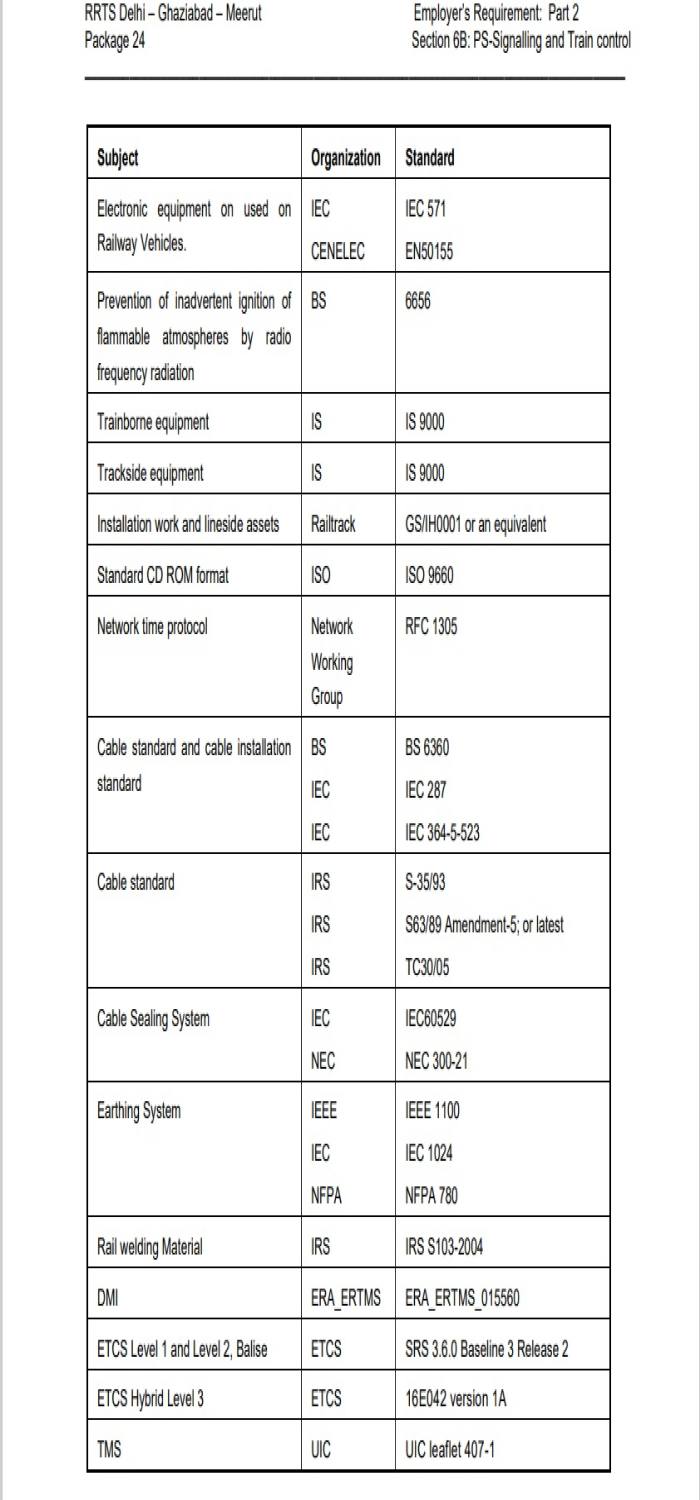

RRTS Dethi— Ghaziabad — Meerut
Package 24

Employer's Requirement: Part 2
Section 8B: PS-Signaliing and Train control

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

Subject Organization | Standard
Electronic equipment on used on | IEC IEC 671
Railway Vehicles. CENELEC ENS0155
Prevention of inadvertent ignition of | BS 6656
flammable atmospheres by radio
frequency radiation
Trainborne equipment s '$ 9000
Trackside equipment s '$ 9000
Installation work and lineside assets | Railtrack GSVH0001 or an equivalent
Standard CD ROM format 'so 180 9660
Network time protocol Network RFC 1305
Working
Group
Cable standard and cable installation | BS BS 6360
standard IEC IEC 287
IEC IEC 364-5-523
Cable standard IRS 835/93
IRS 863/89 Amendment-5; or latest
IRS To30/05
Cable Sealing System IEC 1Ec60s29
NEC NEC 300-21
Earthing System IEEE IEEE 1100
IEC IEC 1024
NFPA NFPA 780
Rail welding Material IRS IRS 8103-2004
DMI ERA_ERTMS | ERA_ERTMS_015560
ETCS Level 1 and Level 2, Balise ETCS SRS 

In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
#import pillow 

""""
#Since scanned PDF can't be handled by pdf2image, convert the scanned PDF into a JPEG format using the below code- 
filename = path   
from pdf2image import convert_from_path 
pages = convert_from_path(filename, 500) for page in pages:
page.save("dest", 'JPEG')
"""

imgname = '/content/drive/MyDrive/ZeoanAI_Poc/IMG-20210922-WA0006.jpg'
oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
cv2_imshow(oriimg)



#img = cv2.resize(oriimg,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC) 
img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
#here length height  
cv2_imshow( img)  
cv2.imwrite("changed_dimensionsimgpath.jpg", img)


import PIL.Image  

image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv2.imwrite("/content/newim.jpg", grayedimg)

# resolve (2, 'Usage: pytesseract [-l lang] input_file') on Google Colab
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

img = PIL.Image.open("/content/newim.jpg")
text = pytesseract.image_to_string(img, lang="eng", config='--psm 3')
print(text)
d = pytesseract.image_to_data(img, output_type=Output.DICT,lang="eng", config='--psm 3')
print(d)
df_example1 = pytesseract.image_to_data(img,lang='eng',config='-psm 6', output_type='data.frame')
print(df_example1)

In [ ]:
df_example1.to_csv('sample.csv',index=False)

In [ ]:
df_example1.iloc[111:][df_example1['level']==5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


level  page_num  block_num  par_num  ...  width  height  conf        text
111      5         1         23        1  ...    842     880    83           |
112      5         1         23        1  ...     58      10    89    Standard
114      5         1         23        1  ...     59      10    39  Electronic
115      5         1         23        1  ...     63      12    81   equipment
116      5         1         23        1  ...     14       7    86          on
..     ...       ...        ...      ...  ...    ...     ...   ...         ...
285      5         1         23        1  ...     38      10    76     leaflet
286      5         1         23        1  ...     34      10    96       407-1
290      5         1         24        1  ...      3     791    95            
294      5         1         25        1  ...      4     791    95            
298      5         1         26        1  ...    631       2    95            

[151 rows x 12 columns]

##Example 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## installing dependencies

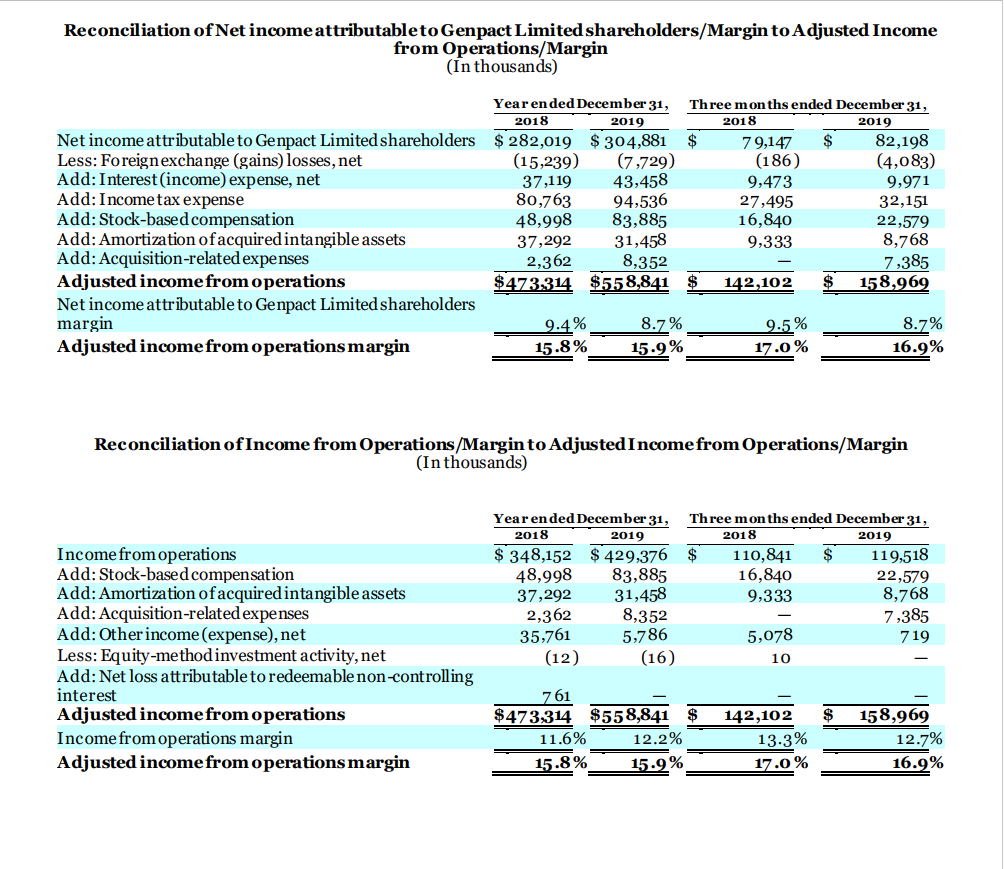

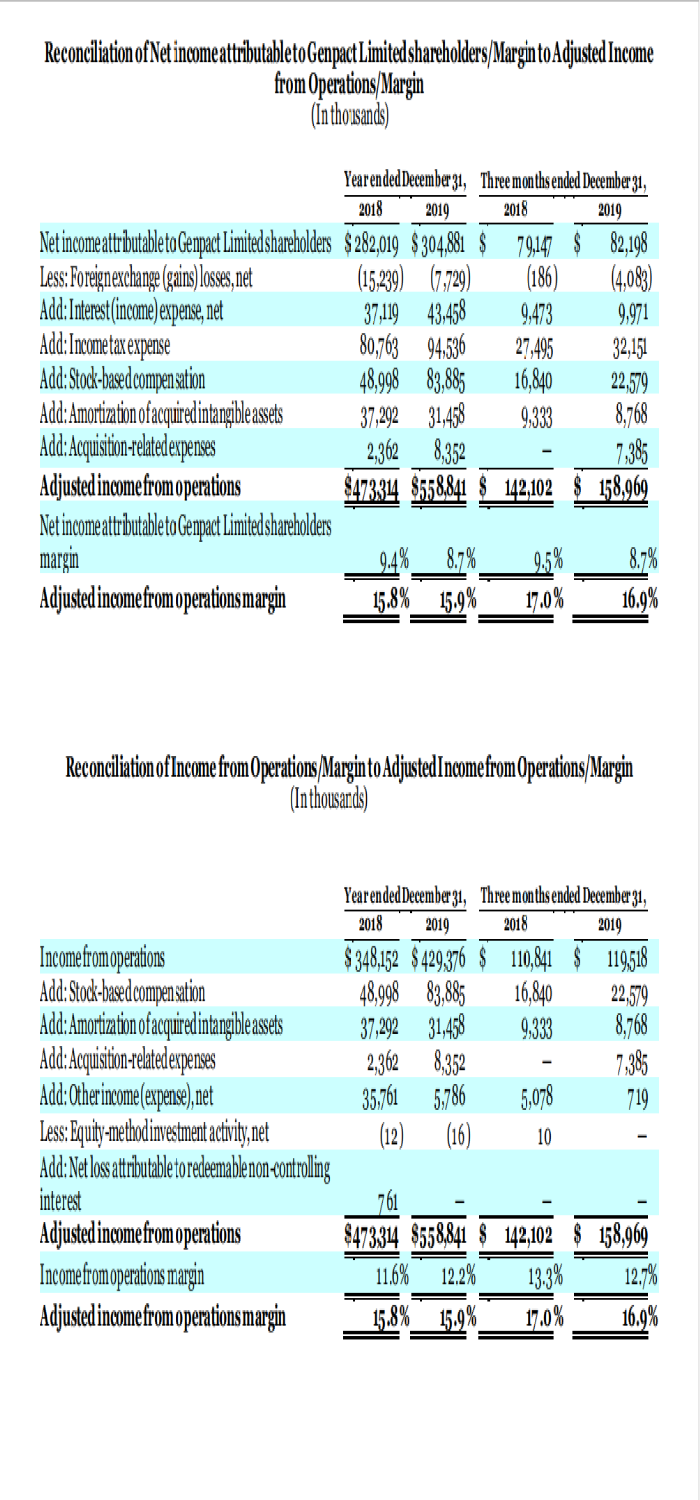

Reconciliation of Net income attributable to Genpact Limited shareholders/Margin to Adjusted Income

from Operations/Margin
(In thousands)

YearendedDecember31, Three months ended December 31,

“aos ——s0g CO
Netincomeattributableto Genpact Limitedshareholders $282,019 $304,881 § 79147 $ 82,198
Less: Foreignexchange (gains) losses, net (15,239) (7,729) (186) (4,083)
Add: Interest (incame) expense, net 37,19 © 43,458 9,473 9,971
Add: Income tax expense 80,763 94,536 27,495 32,151
Add: Stock-based compensation 48,998 83,885 16,840 22,579
Add: Amortization of acquired intangible assets 37,292 31,458 9,333 8,768
Add: Acquisition-related expenses _ "2,362 8,352 7,385
Adjusted income from operations $473914 §558841 § 142,102 § 158,969
Net income attributable to Genpact Limited shareholders
margin 9.4% 8.7% 9.5% 8.7%

Adjusted income from operations margin %

  

   

Reconciliation of Income from Operations /Margin to Adjusted neome from Operations/Margin
(In thousands)

YearendedDecember 31,

In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from google.colab.patches import cv2_imshow
#import pillow 

""""
#Since scanned PDF can't be handled by pdf2image, convert the scanned PDF into a JPEG format using the below code- 
filename = path   
from pdf2image import convert_from_path 
pages = convert_from_path(filename, 500) for page in pages:
page.save("dest", 'JPEG')
"""

imgname = '/content/drive/MyDrive/ZeoanAI_Poc/Finance statement page.png'
oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
cv2_imshow(oriimg)



#img = cv2.resize(oriimg,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC) 
img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
#here length height  
cv2_imshow( img)  
cv2.imwrite("changed_dimensionsimgpath.jpg", img)


import PIL.Image  

image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv2.imwrite("/content/newim.jpg", grayedimg)

# resolve (2, 'Usage: pytesseract [-l lang] input_file') on Google Colab
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')


text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
print(text)
df_example1 = pytesseract.image_to_data(PIL.Image.open("/content/newim.jpg"),lang='eng',config='-psm 6', output_type='data.frame')

In [ ]:
df_example1.head(30)

level  page_num  block_num  ...  height  conf                  text
0       1         1          0  ...     869    -1                   NaN
1       2         1          1  ...      17    -1                   NaN
2       3         1          1  ...      17    -1                   NaN
3       4         1          1  ...      17    -1                   NaN
4       5         1          1  ...      13    96        Reconciliation
5       5         1          1  ...      13    87                    of
6       5         1          1  ...      12    87                   Net
7       5         1          1  ...      13    92                income
8       5         1          1  ...      13    82          attributable
9       5         1          1  ...      11    78                    to
10      5         1          1  ...      16    78               Genpact
11      5         1          1  ...      13    93               Limited
12      5         1          1  ...      17    92   shareholders/Margin
13      5         1          1  ...      11    96                    to
14      5         1          1  ...      17    96              Adjusted
15      5         1          1  ...      12    94                Income
16      2         1          2  ...     293    -1                   NaN
17      3         1          2  ...      34    -1                   NaN
18      4         1          2  ...      17    -1                   NaN
19      5         1          2  ...      13    93                  from
20      5         1          2  ...      17    93     Operations/Margin
21      4         1          2  ...      16    -1                   NaN
22      5         1          2  ...      16    94                   (In
23      5         1          2  ...      16    95            thousands)
24      3         1          2  ...      14    -1                   NaN
25      4         1          2  ...      14    -1                   NaN
26      5         1          2  ...      13    84  YearendedDecember31,
27      5         1          2  ...      10    66                 Three
28      5         1          2  ...      10    94                months
29      5         1          2  ...      10    94                 ended

[30 rows x 12 columns]

## Description of the columns generated for the Dataframe

* level: hierarchical layout (a word is in a line, which is in a paragraph, which is in a block, which is in a page), a value from 1 to 5
    * 1: page, 
    * 2: block, 
    * 3: paragraph, 
    * 4: line, 
    * 5: word

* page_num: when provided with a list of images, indicates the number of the file, when provided with a multi-pages document, indicates the page number, starting from 1

* block_num: block number within the page, starting from 0

* par_num: paragraph number within the block, starting from 0

* line_num: line number within the paragraph, starting from 0

* word_num: word number within the line, starting from 0
* left: x coordinate in pixels of the text bounding box top left corner, starting from the left of the image
* top: y coordinate in pixels of the text bounding box top left corner, starting from the top of the image
* width: width of the text bounding box in pixels

* height: height of the text bounding box in pixels

* conf: confidence value, from 0 (no confidence) to 100 (maximum confidence), -1 for all level except 5

* text: detected text, empty for all levels except 5

## Example 2

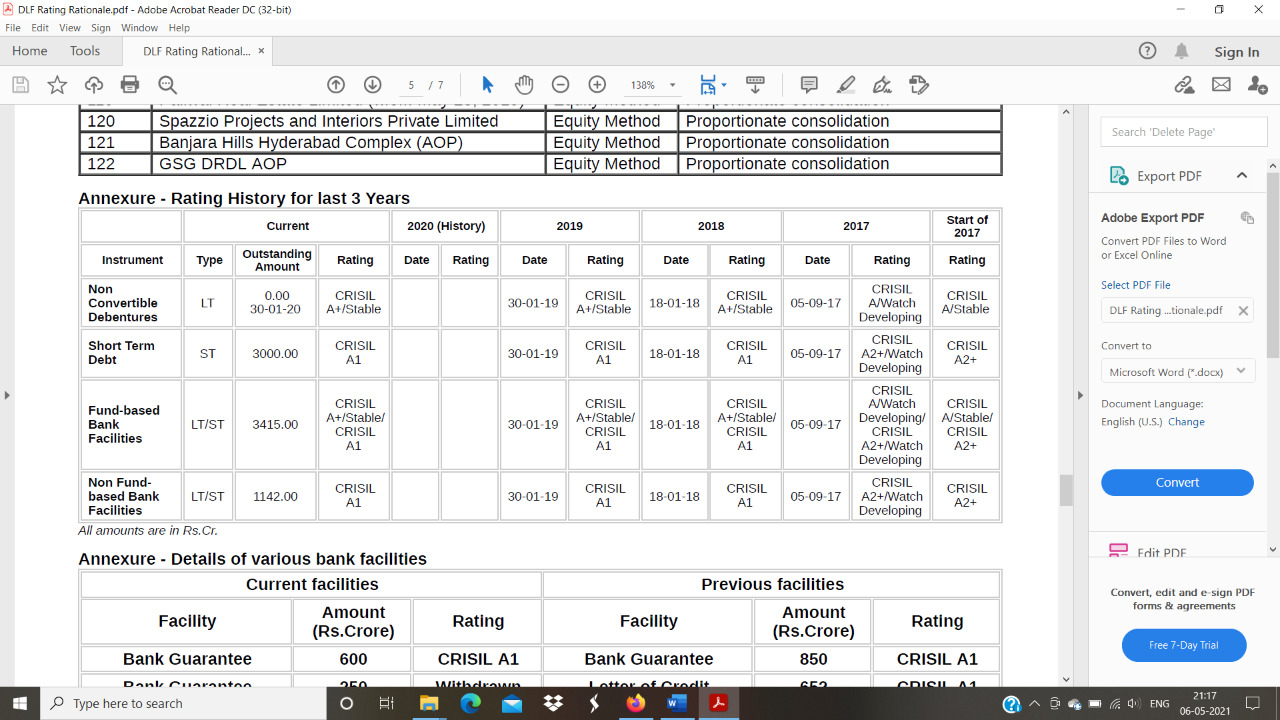

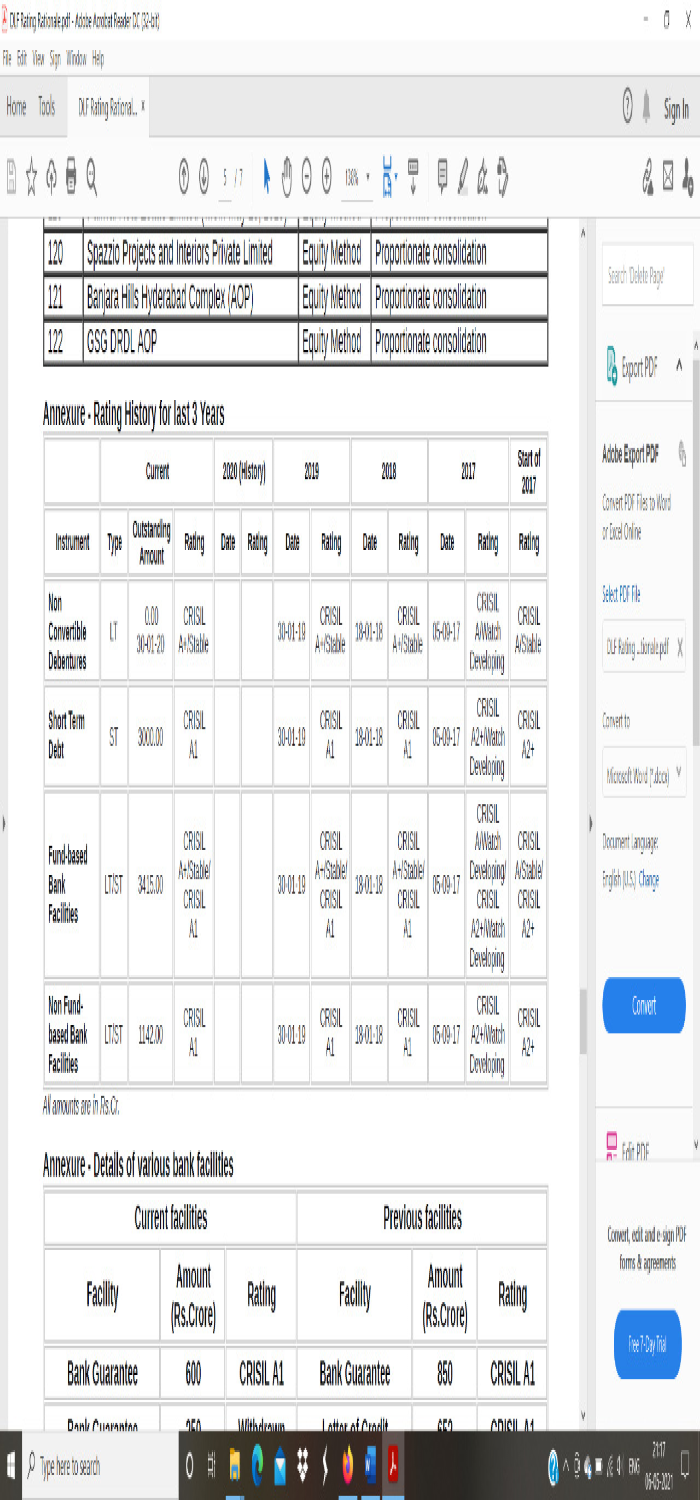

“2 DLE Rating Rationale.pdt - Adee Acrobat Reader DC (32-bit) mx

 

a © sienm
weea @Or -OOOm- fF BLAD & Ete

‘S$pazzio Projects and Interiors Private Limited Equity Method | Proportionate consolidation

Banjara Hills Hyderabad Complex (AOP’ Equity Method _[ Proportionate consolidation

GSG DRDL AOP Equity Method _| Proportionate consolidation .
BR Exportpor

   
 

Annexure - Rating History for last 3 Years

 

 

 

ccurent 2020 (History 2019 ore 0x7 stan ot Aaa EDR
mstument Type O18#S!8NEING sting pate Rating Date. —=—«RatIng ~=—=sDate, == Rating’ «== sate, «= Rating «Rating or Excel Satine
Nea 0.00 CRISIL, CRISIL CRISIL CHIRIL CRISIL, SPREE TS
Hh sgonea  adSlable PG piistabie THO aris OUR AMM ete ee ae
Shon tem — ggg gy CRISTL soot PS genie RSL geoaay ASRS RIS ceva
Debt 7 AL =e AL a AL eae Setisey AQt
Developing Miniesch Was fdeu >
5 crtsit :
Furie cast cris crsit ech crv ene ogg
aiBteter sSBtter nter obvdopngy Altar ene
oar Gist 3816.00 Spas soos “aise O11 “Saige 050847 Oa “ERIS S

In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from google.colab.patches import cv2_imshow
#import pillow 

""""
#Since scanned PDF can't be handled by pdf2image, convert the scanned PDF into a JPEG format using the below code- 
filename = path   
from pdf2image import convert_from_path 
pages = convert_from_path(filename, 500) for page in pages:
page.save("dest", 'JPEG')
"""

imgname = '/content/drive/MyDrive/ZeoanAI_Poc/Amrit_Table.jpeg'
oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
cv2_imshow(oriimg)



#img = cv2.resize(oriimg,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC) 
img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
#here length height  
cv2_imshow( img)  
cv2.imwrite("changed_dimensionsimgpath.jpg", img)


import PIL.Image  

image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv2.imwrite("/content/newim.jpg", grayedimg)

# resolve (2, 'Usage: pytesseract [-l lang] input_file') on Google Colab
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')


text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
print(text)

## Example 3

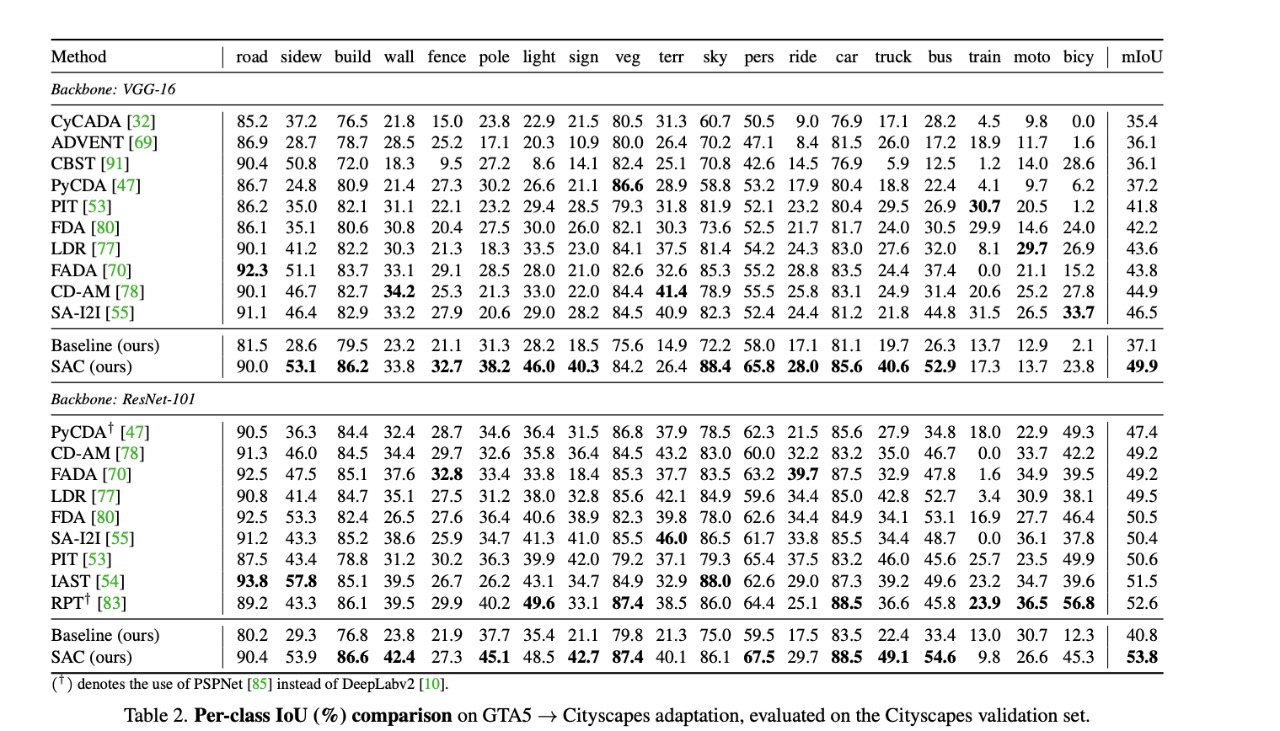

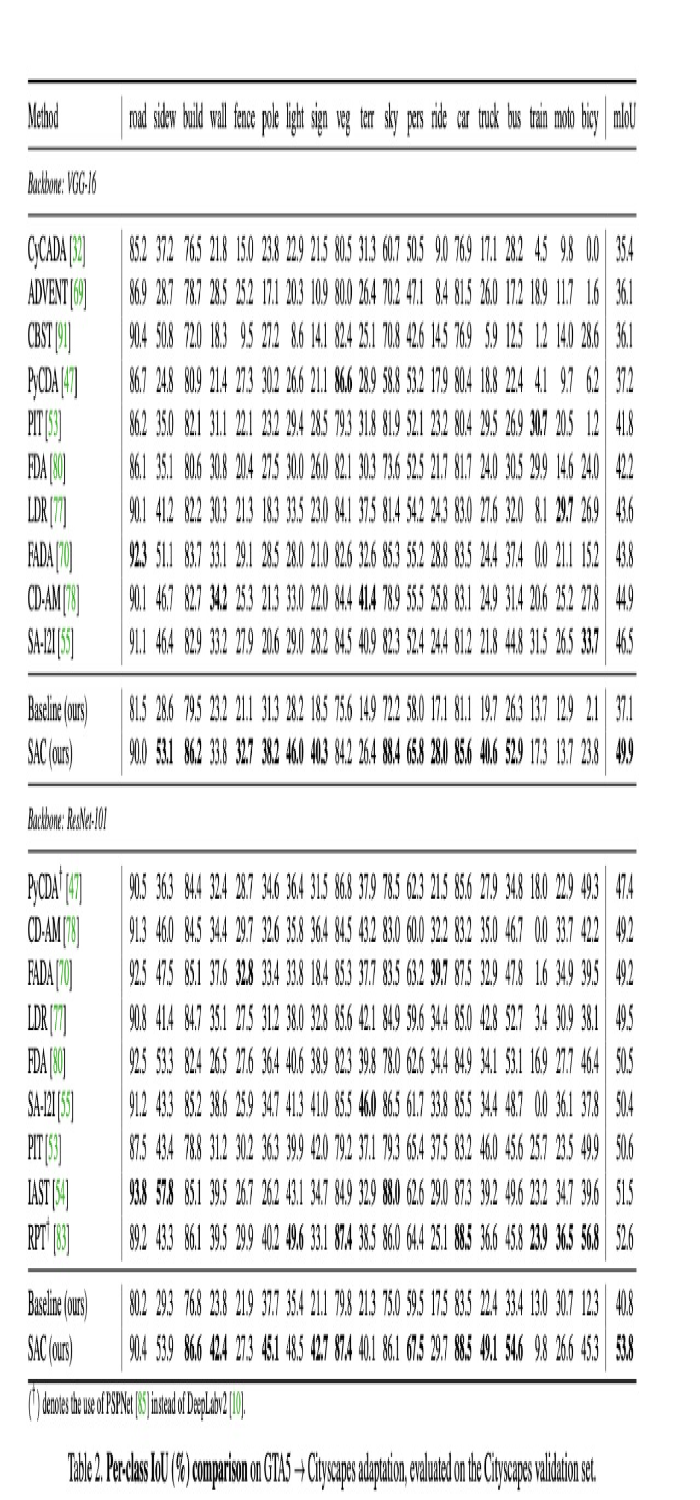

 

 

 

 

 

 

 

Method road sidew build wall fence pole light sign veg terr sky pers tide car truck bus train moto bicy | mloU
Backbone: VGG-16

CyCADA [32] 85.2 37.2 765 218 15.0 238 229 21.5 80.5 31.3 60.7 50.5 9.0 769 17.1 282 45 98 00| 354
ADVENT (64] 86.9 28.7 787 28.5 25.2 17.1 20.3 10.9 80.0 264 70.2 47.1 84 815 260 172 189 11.7 16] 36.1
CBST [91] 90.4 508 720 183 9.5 27.2 &6 141 824 25.1 708 426 145 769 5.9 125 12 14.0 286 | 36.1
PyCDA [17] 86.7 248 80.9 214 27.3 30.2 26.6 21.1 86.6 28.9 588 53.2 179 804 188 224 41 9.7 62 | 372
PIT [53] 86.2 35.0 82.1 31.1 22.1 23.2 294 285 79.3 31.8 B19 52.1 23.2 804 29.5 269 30.7 205 12] 418
FDA [80] 86.1 35.1 80.6 30.8 20.4 27.5 30.0 26.0 82.1 30.3 73.6 52.5 21.7 81.7 24.0 305 299 146 24.0 | 42.2
LR (77) 90,1 41.2 82.2 30.3 21.3 18.3 335 23.0 84.1 37.5 814 54.2 24.3 83.0 27.6 32.0 8&1 297 269] 436
FADA [70] 92.3 51.1 83.7 33.1 29.1 28.5 280 21.0 82.6 32.6 85.3 55.2 288 835 244 374 0.0 214 152] 438
CD-AM [7X] 90,1 46.7 82.7 34.2 25.3 21.

In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from google.colab.patches import cv2_imshow
#import pillow 

""""
#Since scanned PDF can't be handled by pdf2image, convert the scanned PDF into a JPEG format using the below code- 
filename = path   
from pdf2image import convert_from_path 
pages = convert_from_path(filename, 500) for page in pages:
page.save("dest", 'JPEG')
"""

imgname = '/content/drive/MyDrive/ZeoanAI_Poc/Benchmarking Table.jpeg'
oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
cv2_imshow(oriimg)



#img = cv2.resize(oriimg,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC) 
img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
#here length height  
cv2_imshow( img)  
cv2.imwrite("changed_dimensionsimgpath.jpg", img)


import PIL.Image  

image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv2.imwrite("/content/newim.jpg", grayedimg)

# resolve (2, 'Usage: pytesseract [-l lang] input_file') on Google Colab
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')


text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
print(text)
df_example2 = pytesseract.image_to_data(PIL.Image.open("/content/newim.jpg"),lang='eng',config='-psm 6', output_type='data.frame')

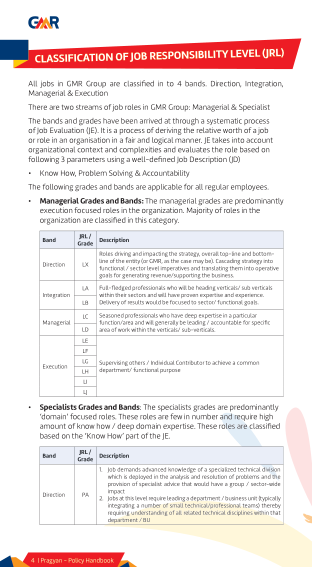

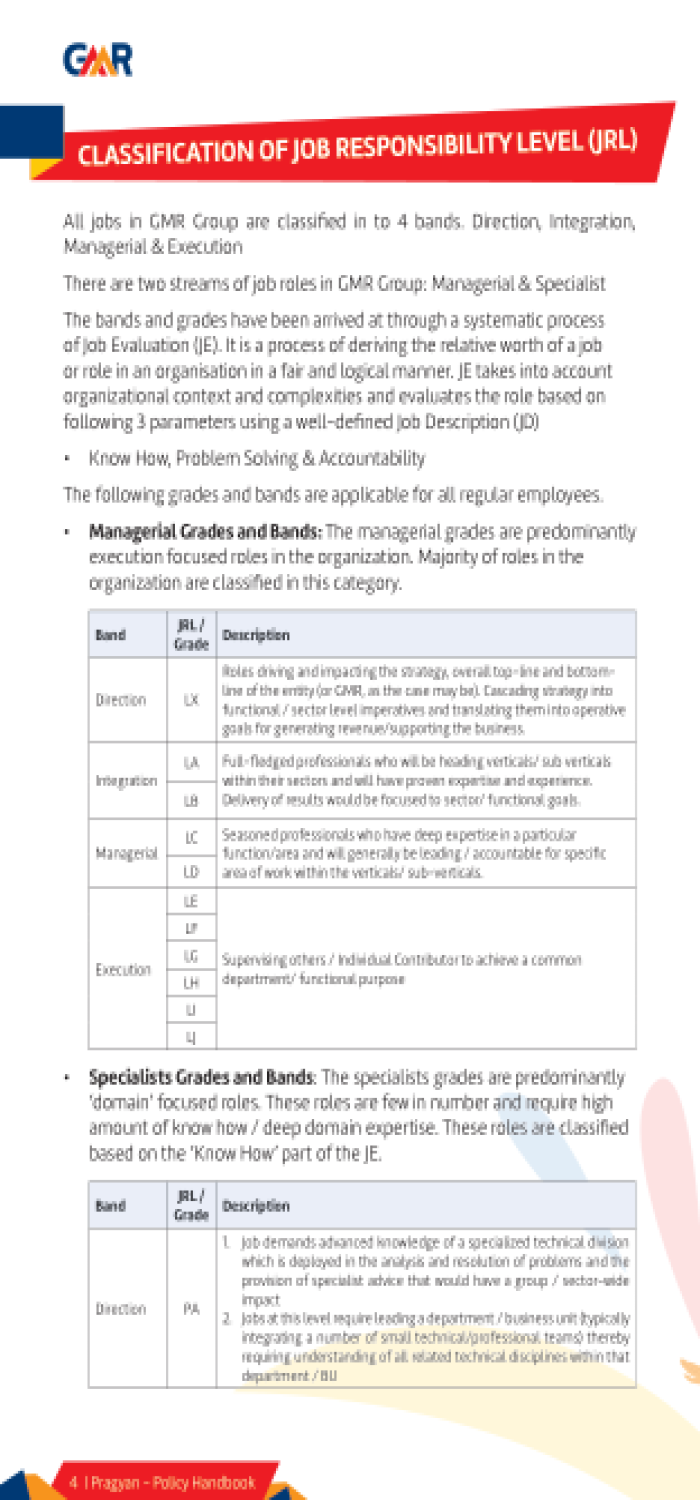

CR

reese cate

 

SLR RO coe wc cots mons ren meet
‘haat snr etic cae apts
‘Pron Emacen fh iies wate e'deing ne nove watta
Sener aumtatn dence ena
He ereesienreens Serre

 

+ Munger susand ane raga aces ae cor cont
Siiietuenedin acetate, en

   

 

 

* Speaus craet and Bots The soci ales se peconi ty
‘Greeters icra one tnt eh
teed othe Macnn Petar " ™

   
   



In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from google.colab.patches import cv2_imshow
#import pillow 

""""
#Since scanned PDF can't be handled by pdf2image, convert the scanned PDF into a JPEG format using the below code- 
filename = path   
from pdf2image import convert_from_path 
pages = convert_from_path(filename, 500) for page in pages:
page.save("dest", 'JPEG')
"""

imgname = '/content/outfile.png'
oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
cv2_imshow(oriimg)



#img = cv2.resize(oriimg,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC) 
img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
#here length height  
cv2_imshow( img)  
cv2.imwrite("changed_dimensionsimgpath.jpg", img)


import PIL.Image  

image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv2.imwrite("/content/newim.jpg", grayedimg)

# resolve (2, 'Usage: pytesseract [-l lang] input_file') on Google Colab
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')


text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
print(text)
df_example2 = pytesseract.image_to_data(PIL.Image.open("/content/newim.jpg"),lang='eng',config='-psm 6', output_type='data.frame')

In [ ]:
df_example2.head(-30)

level  page_num  block_num  par_num  ...  width  height  conf  text
4        5         1          1        1  ...   1113       2    95      
8        5         1          2        1  ...   1112       1    95      
12       5         1          3        1  ...   1112       2    95      
16       5         1          4        1  ...   1112       1    95      
20       5         1          5        1  ...   1112       1    95      
..     ...       ...        ...      ...  ...    ...     ...   ...   ...
603      5         1          8        3  ...     31      13    92   266
604      5         1          8        3  ...     31      13    27  45.3
605      5         1          8        3  ...   1280     731    27     |
606      5         1          8        3  ...     31      13    89   538
610      5         1          9        1  ...      1     621    95      

[556 rows x 12 columns]

In [ ]:
df_example2.to_csv('example2.csv',index=False)

In [ ]:
import tabula
pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/HR_Policy-GGIAL.pdf"
tabula.read_pdf(pdf_path,pages= '8', stream=True)

[                          Fixed Components                              My Plan (FCBP)
 0             Basic Pay (40% of Fixed CTC)  House Rent Allowance (0, 50% of Basic Pay)
 1                              Special Pay      Transport Allowance (` 1600 per month)
 2                          Sodexo Vouchers                          Children Education
 3                  Group Mediclaim Premium     Medical Reimbursement (Monthly/ Annual)
 4       Bonus/ Exgratia (10% of Basic Pay)                              Fuel Allowance
 5        Provident Fund (12% of Basic Pay)     Gift Voucher (Worth ` 5000/- per annum)
 6  Superannuation (8% or 15% of Basic Pay)               Leave Travel Assistance (LTA),
    LTA (Per Annum)Level Petrol Allowance                   Unnamed: 0
 0                                    NaN  (May choose any one amount)
 1           ` 16,000/- per month LX & LA                          NaN
 2              (including driver salary)                          NaN
 3         

## Function to read pdf and extract tables fromthe pages which contains table  and convert to text /Dataframe

In [ ]:
def table2text(img_path,page):
  imgname = img_path
  oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
  cv2_imshow(oriimg)
  img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
  cv2_imshow( img)  
  cv2.imwrite("changed_dimensionsimgpath.jpg", img)
  image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
  grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
  cv2.imwrite("/content/newim.jpg", grayedimg)
  pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
  #
  text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
  #
  print(text)
  df_example2 = pytesseract.image_to_data(PIL.Image.open("/content/newim.jpg"),lang='eng',config='-psm 6', output_type='data.frame')
  filename = 'pdf_page_' + str(page)+'.csv'
  df_example2.to_csv(filename,index=False)


In [ ]:
!pip install -q tabula-py

     |████████████████████████████████| 12.0 MB 7.3 MB/s 


In [ ]:
import cv2
import os  
import numpy as np 
import pytesseract
from google.colab.patches import cv2_imshow
from PyPDF2 import PdfFileReader
import PIL.Image   
from pdf2image import convert_from_path 
import tabula
from PyPDF2 import PdfFileReader, PdfFileWriter
#import fitz
#
def table2text(img_path,page):
  imgname = img_path
  oriimg = cv2.imread(imgname,cv2.IMREAD_COLOR) 
  cv2_imshow(oriimg)
  img = cv2.resize(oriimg,(700,1500),interpolation=cv2.INTER_AREA) 
  cv2_imshow( img)  
  cv2.imwrite("changed_dimensionsimgpath.jpg", img)
  image = cv2.imread(imgname,cv2.IMREAD_COLOR) 
  grayedimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  grayedimg = cv2.threshold(grayedimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
  cv2.imwrite("/content/newim.jpg", grayedimg)
  pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
  #
  text = pytesseract.image_to_string(PIL.Image.open("/content/newim.jpg"), lang="eng", config='-psm 6')
  #
  print(text)
  df_example2 = pytesseract.image_to_data(PIL.Image.open("/content/newim.jpg"),lang='eng',config='-psm 6', output_type='data.frame')
  filename = 'pdf_page_' + str(page)+'.csv'
  df_example2.to_csv(filename,index=False)
#
	

In [ ]:
#Read Image
r = Image.open('8.png')
r.load()
#Converting inmage to text with preserving interline spaces
text = pytesseract.image_to_string(r,config='-c preserve_interword_spaces=1x1 --psm 
1 --oem 3' )

## Function to read the document which has a table and pass it to the function to convert it to image

In [ ]:
def pdf2image_t(pdf_path):
  pdf = PdfFileReader(open(pdf_path,'rb'))
  no_pages = pdf.getNumPages()
  for i in range(1,no_pages +1):
    dfs = tabula.read_pdf(pdf_path,pages=str(i), stream=True,multiple_tables=True)
    # read_pdf returns list of DataFrames
    if len(dfs) > 0:
      print(f"page number {i}")

pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/Tables.pdf"
pdf2image_t(pdf_path)

In [ ]:
def pdf2image_text(pdf_path):
  pdf = PdfFileReader(open(pdf_path,'rb'))
  no_pages = pdf.getNumPages()
  for i in range(1,no_pages +1):
    dfs = tabula.read_pdf(pdf_path,pages=str(i), stream=True,multiple_tables=True)
    # read_pdf returns list of DataFrames
    print(len(dfs))
    if len(dfs) > 0:
      print(dfs[0].head())
      pdf_writer = PdfFileWriter()
      pdf_writer.addPage(pdf.getPage(i))
      output_filename = f'/content/new_pdf_{i}.pdf'
      with open(output_filename,'wb') as out:
            pdf_writer.write(out)
      filename = output_filename
      pages = convert_from_path(filename,1000)
      for page in pages:
        dest_name = "/content/dest_"+str(i)+".jpg"
        page.save(dest_name, 'JPEG')
      image_path = dest_name 
      print(image_path)
      PIL.Image.open(image_path)
      table2text(image_path,i)

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [ ]:
import fitz
#PyMuPDF, output to png file.
pdffile = "/content/new_pdf_4.pdf"
doc = fitz.open(pdffile)
page = doc.loadPage(0)  # number of page
pix = page.getPixmap()
output = "outfile.png"
pix.writePNG(output)

In [ ]:
pdf_path = "/content/drive/MyDrive/ZeoanAI_Poc/Tables.pdf"
pdf2image_text(pdf_path)

0
0
0
